You can download the HI4PI data from http://cdsarc.u-strasbg.fr/viz-bin/qcat?J/A+A/594/A116. <br>
* To get the relevant cubes, go to the FTP tab, select CUBES, then EQ2000, then CAR (meaning the cube data are organized in Cartesian projection). <br>
* Each cube covers a 20x20 deg2 region in RA and DEC. You can check the coverage range of each cube here: https://github.com/yzhenggit/yzGALFAHI/blob/master/HI4PI_RADEC.dat <br>
* For data information (resolution, sensitivity, etc) related to HI4PI and other HI survey, you can check table 1 in Josh's paper: https://ui.adsabs.harvard.edu/abs/2018ApJS..234....2P/abstract <br>


If you want to download GALFA-HI, which has a finer angular resolution than HI4PI, you can click on the link in Table 3 of Josh's paper above (wide cubes, meaning it covers a wide range of velocity, something like +/-600 km/s. The narrow cubes have a better velocity resolution, but narrower velocity range). HI4PI is probably a better choice for your project. These GALFA-HI information is sort of irrevalent to what you want to do, but I thought it might be useful to include in case you are curious :) <br> 

This notebook works for both HI4PI and GALFA-HI cube. And should work for LAB cubes too, but might need some testing. <br>

All velocities in these cubes are in heliocentric frame. So you'll need to convert vhelio to vlsr. If you don't have the conversion tool yet, check out this one: https://github.com/yzhenggit/yztools/blob/master/vhelio2vlsr.py, and use the vhelio2vlsr_Westmeier function. 

In [1]:
%matplotlib inline 
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.io.fits as fits 
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt 

# you can download get_cubeinfo.py from my github
# https://github.com/yzhenggit/yzGALFAHI/blob/master/get_cubeinfo.py
# and then change the following to from get_cubeinfo import get_cubeinfo 
from yzGALFAHI.get_cubeinfo import get_cubeinfo 

In [2]:
def extract_HI_from_cube(tar_ra, tar_dec, header, cube_data, radius_deg):
    '''
    tar_ra/tar_dec: the ra/dec for the sightline, in degree
    radius_deg: the radius of the extraction area, in unit of degree
          Note that, HI4PI's beamsize is 16 arcmin
          and GALFA-HI's beamsize is 4 arcmin. 
    '''
    
    # get sky coordinate for the target
    tar_coord = SkyCoord(ra=tar_ra*u.deg, dec=tar_dec*u.deg, frame='icrs')
    print('Sightline: RA=%.2f, DEC=%.2f, l=%.2f, b=%.2f (degree)'%(tar_ra, tar_dec, 
                                                                   tar_coord.galactic.l.degree, 
                                                                   tar_coord.galactic.b.degree))
    print('Extracted within radius: %.2f arcmin (%.2f deg)'%(radius_deg*60, radius_deg))
    
    # parse the cube header information to get RA/DEC coordinators 
    cube_ra, cube_dec, cube_vel = get_cubeinfo(header)
    cube_coord = SkyCoord(ra=cube_ra*u.deg, dec=cube_dec*u.deg, frame='icrs')
    print('Cube RA range: [%.2f, %.2f], DEC range: [%.2f, %.2f]'%(cube_ra[0, -1], 
                                                                  cube_ra[0, 0], 
                                                                  cube_dec[0, 0], 
                                                                  cube_dec[-1, 0]))
    
    # calculate the distance between the sightline and the whole cube
    dist_coord = tar_coord.separation(cube_coord)
    dist_deg = dist_coord.degree # distance in degree 
    
    # this create a 2d mask of [Dec, RA]
    within_r_2d = dist_deg<=radius_deg/2. # beam should be in unit of degree. 
    print('2D MASK data shape: ', within_r_2d.shape)
    
    # this creates a 3 mask of (Vhel, Dec, RA) so that we can use it to take out the spec within the search area 
    within_r_3d = np.asarray([within_r_2d]*cube_vel.size)
    print('3D MASK data shape: ', within_r_3d.shape)
    
    # 3D mask shape should be the same as the data cube shape 
    print('cube data shape: ', cube_data.shape)

    # now mask the data 
    data = cube_data.copy()
    data[np.logical_not(within_r_3d)] = np.nan

    # take the mean value along the Dec (axis=2) and the RA (axis=1) directions 
    mean_spec = np.nanmean(np.nanmean(data, axis=2), axis=1)
    
    return cube_vel, mean_spec

Specify the target sightline's coordinate, and read in the relevant cube 

In [3]:
tar_ra = 150  # deg
tar_dec = 20 # deg

# here I want to extract mean spectra from one beam, in unit of degree 
# you can do 30 arcmin, 1 deg, etc. to smooth out the spectra
radius_deg = 16/60. 

cube_file = '/Volumes/YongData2TB/HI4PI/CAR_F08.fits'
header = fits.getheader(cube_file)
cube_data = fits.getdata(cube_file)

Extract HI line

In [4]:
cube_vel, mean_spec = extract_HI_from_cube(tar_ra, tar_dec, header, cube_data, radius_deg)

Sightline: RA=150.00, DEC=20.00, l=213.80, b=50.26 (degree)
Extracted within radius: 16.00 arcmin (0.27 deg)
Cube RA range: [139.00, 161.08], DEC range: [9.00, 31.08]
2D MASK data shape:  (266, 266)
3D MASK data shape:  (933, 266, 266)
cube data shape:  (933, 266, 266)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice


Text(0, 0.5, 'Tb (K)')

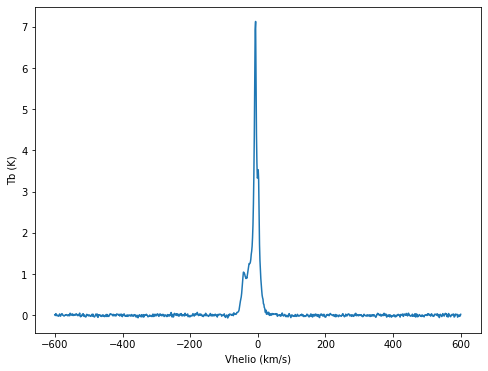

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(cube_vel, mean_spec)
plt.xlabel('Vhelio (km/s)')
plt.ylabel('Tb (K)')